# Household Test

In [24]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
plt.style.use('seaborn-whitegrid')
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

from BabyMAKROModel import BabyMAKROModelClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [25]:
model = BabyMAKROModelClass(name='Extended')

In [26]:
par = model.par
ss = model.ss
sol = model.sol

# Labor supply

In [27]:
par.m_s_ss

0.5

In [28]:
from steady_state import households_search_ss
ss.m_s = par.m_s_ss # required input

In [29]:
households_search_ss(par, ss)

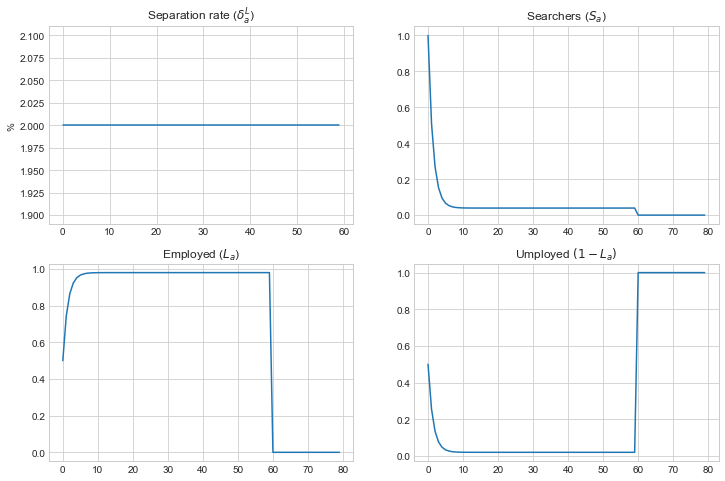

In [30]:
fig = plt.figure(figsize=(2*6,2*6/1.5))

ax = fig.add_subplot(2,2,1)
ax.plot(par.delta_L_a*100)
ax.set_ylabel('%')
ax.set_title('Separation rate ($\delta^L_a$)');

ax = fig.add_subplot(2,2,2)
ax.plot(ss.S_a)
ax.set_title('Searchers ($S_a$)')

ax = fig.add_subplot(2,2,3)
ax.plot(ss.L_a)
ax.set_title('Employed ($L_a$)')

ax = fig.add_subplot(2,2,4)
ax.plot(1-ss.L_a)
ax.set_title('Umployed $(1-L_a)$');

In [31]:
ss.L

57.881584006151485

In [32]:
from steady_state import find_household_consumption_ss, household_ss

**Required inputs:**

In [33]:
ss.W = 2.6677876623451535
ss.pi_hh = par.pi_hh_ss
ss.P_C = 1.0
ss.tau = 0.42
ss.real_r_hh = (1+par.r_hh)/(1+ss.pi_hh)-1

**Solve:**

In [34]:
find_household_consumption_ss(model)

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 1.6346221361002626

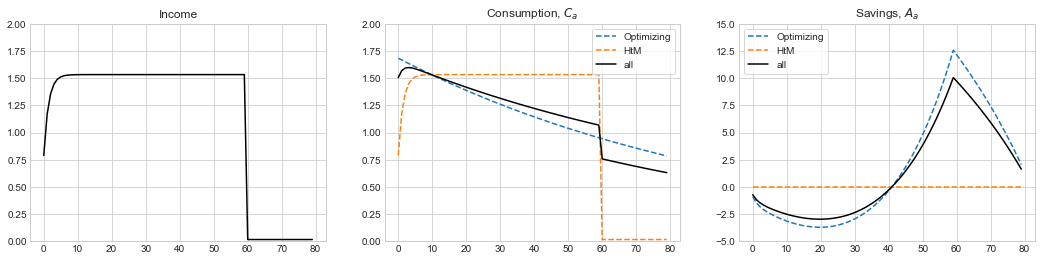

In [39]:
def plot_CA():
    
    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ax = fig.add_subplot(1,3,1)
    ax.plot(ss.inc_a,label='all',color='black')
    ax.set_title('Income')
    ax.set_ylim([0,2])
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ss.C_R_a,ls='--',label='Optimizing')
    ax.plot(ss.C_HtM_a,ls='--',label='HtM')
    ax.plot(ss.C_a,label='all',color='black')
    ax.set_title('Consumption, $C_a$')
    ax.legend(frameon=True)
    ax.set_ylim([0,2])
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ss.B_R_a,ls='--',label='Optimizing')
    ax.plot(ss.B_HtM_a,ls='--',label='HtM')
    ax.plot(ss.B_a,label='all',color='black')
    ax.set_title('Savings, $A_a$')
    ax.set_ylim([-5,15])
    ax.legend(frameon=True)
    
plot_CA()

## Varying central inputs

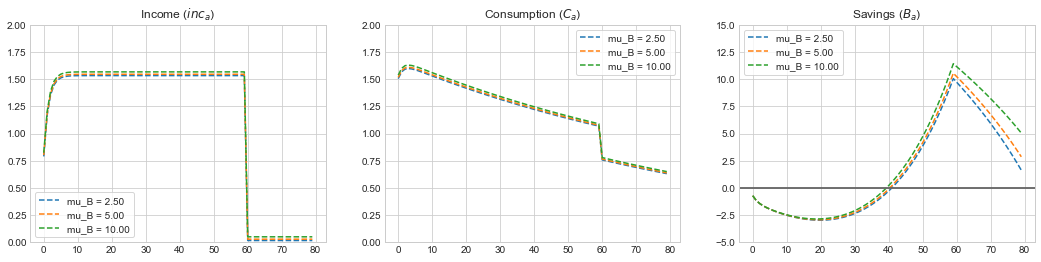

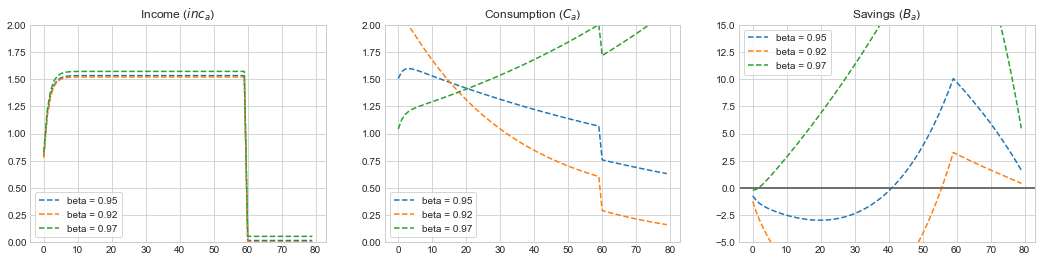

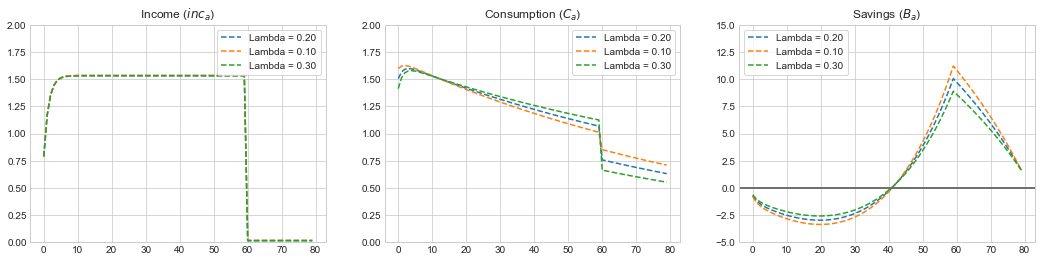

In [41]:
def compare_models(model,name,value1,value2,ns='ss'):
    model_ = model.copy()
    model__ = model.copy()
    
    if ns == 'ss':
        oldvalue = model.ss.__dict__[name]
        model_.ss.__dict__[name] = value1
        model__.ss.__dict__[name] = value2
    elif ns == 'par':
        oldvalue = model.par.__dict__[name]
        model_.par.__dict__[name] = value1
        model__.par.__dict__[name] = value2
    else:
        raise NotImplemented
            
    find_household_consumption_ss(model_)
    find_household_consumption_ss(model__)

    fig = plt.figure(figsize=(3*6,1*6/1.5))

    ax = fig.add_subplot(1,3,1)
    ax.plot(ss.inc_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.inc_a,ls='--',label=f'{name} = {value1:.2f}')
    ax.plot(model__.ss.inc_a,ls='--',label=f'{name} = {value2:.2f}')
    ax.set_title('Income ($inc_{a}$)');
    ax.set_ylim([0,2])
    ax.legend(frameon=True)
    
    ax = fig.add_subplot(1,3,2)
    ax.plot(ss.C_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.C_a,ls='--',label=f'{name} = {value1:.2f}')
    ax.plot(model__.ss.C_a,ls='--',label=f'{name} = {value2:.2f}')
    ax.set_title('Consumption ($C_{a}$)');
    ax.set_ylim([0,2])
    ax.legend(frameon=True)
    
    ax = fig.add_subplot(1,3,3)
    ax.plot(ss.B_a,ls='--',label=f'{name} = {oldvalue:.2f}')
    ax.plot(model_.ss.B_a,ls='--',label=f'{name} = {value1:.2f}')
    ax.plot(model__.ss.B_a,ls='--',label=f'{name} = {value2:.2f}')
    ax.axhline(y=0, color ='dimgrey')
    ax.set_title('Savings ($B_{a}$)')
    ax.axhline(y=0, color ='dimgrey')
    ax.set_ylim([-5,15])    
    ax.legend(frameon = True)
    
compare_models(model,'mu_B',par.mu_B*2,par.mu_B*4,ns='par')
compare_models(model,'beta',par.beta-0.025,par.beta+0.025,ns='par')
compare_models(model,'Lambda',par.Lambda-0.1,par.Lambda+0.1,ns='par')

## Customized Graphs for Calibration

In [44]:
# create new instances
model2 = model.copy()
model3 = model.copy()

name = "beta"

# Change Beta
oldvalue = model.par.__dict__[name]
model2.par.__dict__[name] = oldvalue-0.025
model3.par.__dict__[name] = oldvalue+0.025

In [45]:
find_household_consumption_ss(model)
find_household_consumption_ss(model2)
find_household_consumption_ss(model3)

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 5.4867208832327945

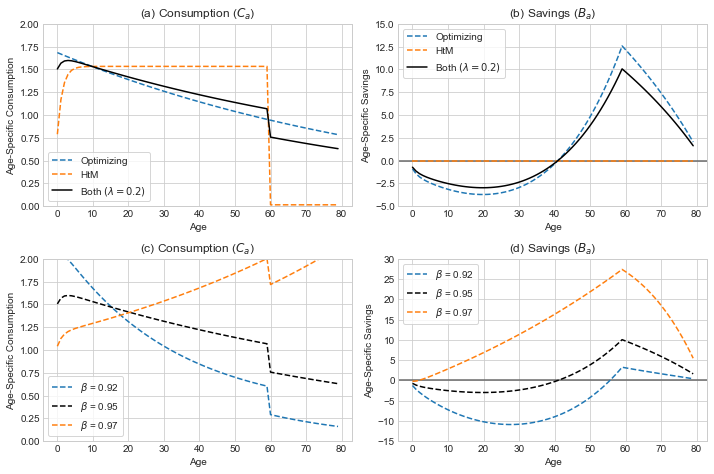

In [50]:
fig = plt.figure(figsize=(2*5,2*5/1.5))

ax = fig.add_subplot(2,2,1)
ax.plot(model.ss.C_R_a,ls='--',label='Optimizing')
ax.plot(model.ss.C_HtM_a,ls='--',label='HtM')
ax.plot(model.ss.C_a,label='Both $(\lambda = 0.2)$',color='black')
ax.set_title('(a) Consumption ($C_a$)')
ax.set_xlabel('Age')
ax.set_ylabel('Age-Specific Consumption')
ax.set_ylim([0,2])
ax.legend(frameon=True)

ax = fig.add_subplot(2,2,2)
ax.axhline(y=0, color ='dimgrey')
ax.plot(model.ss.B_R_a,ls='--',label='Optimizing')
ax.plot(model.ss.B_HtM_a,ls='--',label='HtM')
ax.plot(model.ss.B_a,label='Both $(\lambda = 0.2)$',color='black')
ax.set_title('(b) Savings ($B_a$)')
ax.set_ylabel('Age-Specific Savings')
ax.set_xlabel('Age')
ax.set_ylim([-5,15])
ax.legend(frameon=True)

ax = fig.add_subplot(2,2,3)
ax.plot(model2.ss.C_a,label=r'$\beta$ ' f'= {model2.par.beta:.2f}', linestyle = '--')
ax.plot(model.ss.C_a,label=r'$\beta$ ' f'= {model.par.beta:.2f}', color = 'k', linestyle = '--')
ax.plot(model3.ss.C_a,label=r'$\beta$ ' f'= {model3.par.beta:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Consumption')
ax.set_xlabel('Age')
ax.set_ylim([0,2])
ax.legend(frameon = True)
ax.set_title('(c) Consumption ($C_{a}$)')

ax = fig.add_subplot(2,2,4)
ax.axhline(y=0, color ='dimgrey')
ax.plot(model2.ss.B_a,label=r'$\beta$ ' f'= {model2.par.beta:.2f}', linestyle = '--')
ax.plot(model.ss.B_a,label=r'$\beta$ ' f'= {model.par.beta:.2f}', color = 'k', linestyle = '--')
ax.plot(model3.ss.B_a,label=r'$\beta$ ' f'= {model3.par.beta:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Savings')
ax.set_xlabel('Age')
ax.set_ylim([-15,30])
ax.legend(frameon = True)
ax.set_title('(d) Savings ($B_{a}$)')
fig.tight_layout(pad=1); # spacing between subplots
plt.savefig("CalibrationHH.pdf", format="pdf", bbox_inches="tight")

## Customized Graphs for Appendix

In [64]:
# create new instances
model2 = model.copy()
model3 = model.copy()
model5 = model.copy()
model6 = model.copy()

name1 = "mu_B"
name2 = "Lambda"

# Change parameters mu_B
oldvalue1 = model.par.__dict__[name1]
model2.par.__dict__[name1] = oldvalue1*2
model3.par.__dict__[name1] = oldvalue1*4

# Change lambdq
oldvalue2 = model.par.__dict__[name2]
model5.par.__dict__[name2] = oldvalue2-0.1
model6.par.__dict__[name2] = oldvalue2+0.1

In [65]:
find_household_consumption_ss(model)
find_household_consumption_ss(model2)
find_household_consumption_ss(model3)
find_household_consumption_ss(model5)
find_household_consumption_ss(model6)

      converged: True
           flag: 'converged'
 function_calls: 4
     iterations: 3
           root: 1.6315770413194304

In [72]:
from matplotlib.ticker import FormatStrFormatter

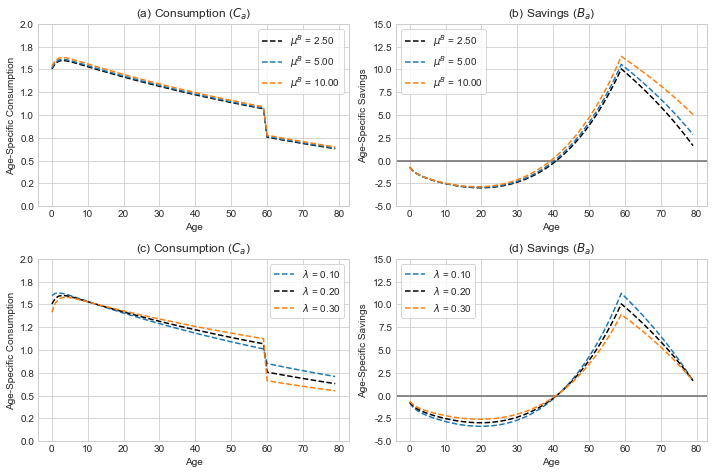

In [74]:
fig = plt.figure(figsize=(2*5,2*5/1.5))

ax = fig.add_subplot(2,2,1)
ax.plot(model.ss.C_a,label=f'$\mu^B$ = {model.par.mu_B:.2f}', color = 'k', linestyle = '--')
ax.plot(model2.ss.C_a,label=f'$\mu^B$ = {model2.par.mu_B:.2f}', linestyle = '--')
ax.plot(model3.ss.C_a,label=f'$\mu^B$ = {model3.par.mu_B:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Consumption')
ax.set_xlabel('Age')
ax.set_ylim([0,2.0])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(frameon = True)
ax.set_title('(a) Consumption ($C_{a}$)')

ax = fig.add_subplot(2,2,2)
ax.axhline(y=0, color ='dimgrey')
ax.plot(model.ss.B_a,label=f'$\mu^B$ = {model.par.mu_B:.2f}', color = 'k', linestyle = '--')
ax.plot(model2.ss.B_a,label=f'$\mu^B$ = {model2.par.mu_B:.2f}', linestyle = '--')
ax.plot(model3.ss.B_a,label=f'$\mu^B$ = {model3.par.mu_B:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Savings')
ax.set_xlabel('Age')
ax.set_ylim([-5,15])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(frameon = True)
ax.set_title('(b) Savings ($B_{a}$)')

ax = fig.add_subplot(2,2,3)
ax.plot(model5.ss.C_a,label=f'$\lambda$ = {model5.par.Lambda:.2f}', linestyle = '--')
ax.plot(model.ss.C_a,label=f'$\lambda$ = {model.par.Lambda:.2f}', color = 'k', linestyle = '--')
ax.plot(model6.ss.C_a,label=f'$\lambda$ = {model6.par.Lambda:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Consumption')
ax.set_xlabel('Age')
ax.set_ylim([0,2])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(frameon = True)
ax.set_title('(c) Consumption ($C_{a}$)')

ax = fig.add_subplot(2,2,4)
ax.axhline(y=0, color ='dimgrey')
ax.plot(model5.ss.B_a,label=f'$\lambda$ = {model5.par.Lambda:.2f}', linestyle = '--')
ax.plot(model.ss.B_a,label=f'$\lambda$ = {model.par.Lambda:.2f}', color = 'k', linestyle = '--')
ax.plot(model6.ss.B_a,label=f'$\lambda$ = {model6.par.Lambda:.2f}', linestyle = '--')
ax.set_ylabel('Age-Specific Savings')
ax.set_xlabel('Age')
ax.set_ylim([-5,15])
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.legend(frameon = True)
ax.set_title('(d) Savings ($B_{a}$)')

fig.tight_layout(pad=1); # spacing between subplots
plt.savefig("CalibrationHHAppendix.pdf", format="pdf", bbox_inches="tight")

# Test household blocks

In [75]:
ss.B_a[:] = ss.B_a
sol.P_C[:] = ss.P_C
sol.W[:] = ss.W
sol.tau[:] = ss.tau
sol.L[:] = ss.L
sol.m_s[:] = ss.m_s
sol.real_r_hh[:] = ss.real_r_hh

In [76]:
model.ini = ss

In [77]:
from blocks import household_search, households_consumption

In [78]:
model.evaluate_block('household_search')

In [79]:
assert np.allclose(sol.S_a-ss.S_a[:,np.newaxis],0.0)
assert np.allclose(sol.L_ubar_a-ss.L_ubar_a[:,np.newaxis],0.0)
assert np.allclose(sol.L_a-ss.L_a[:,np.newaxis],0.0)
assert np.allclose(sol.S-ss.S,0.0)
assert np.allclose(sol.L_ubar-ss.L_ubar,0.0)

In [80]:
model.evaluate_block('households_consumption')